In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from numpy import asarray
from tensorflow.keras.layers import Input,Embedding,GRU,MaxPooling2D,GlobalMaxPooling2D,Bidirectional,Attention,TimeDistributed
from tensorflow.keras.layers import LSTM,Concatenate,MaxPool1D,Flatten,Dropout,Masking,Softmax,Dense,Embedding
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TerminateOnNaN,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.models import Sequential
#BPEmb is set of pretrained vectors like glove vectors
from bpemb import BPEmb
from tqdm import tqdm

### Importing Data

In [2]:
#Importing Dataset
AllData = pd.read_pickle('DattForAttention.pkl')
AllData.head()

,input Sentence,output Sentence
0,we,have had three meetings which brought out very...
1,we have,had three meetings which brought out very diff...
2,we have had,three meetings which brought out very differen...
3,we have had three,meetings which brought out very different issu...
4,we have had three meetings,which brought out very different issues from d...


## Checking Data

In [19]:
bpemb_en = BPEmb(lang="en",vs=50000)

In [20]:
#As we discussed in the previous steps , we are only having words with more than 14 words
#There for excluding other words. 1 and 2 indicates spaces there fore setting 16 as limit
dataEncoding = bpemb_en.encode_ids_with_bos_eos(AllData['input Sentence'].values+' '+AllData['output Sentence'].values)

In [21]:
bpemb_en.decode_ids(415)

'we'

In [23]:
lenBadWords = 0
indexList = []
for i,ele in enumerate(dataEncoding):
    if len(ele) > 16:
        lenBadWords += 1
        indexList.append(i)
lenBadWords

170119

In [24]:
#Deleting bad Data
AllData.drop(AllData.index[indexList],inplace=True)
AllData.shape

(2348896, 2)

In [25]:
AllData.to_pickle('PreProcessed\AllData_Processed.pkl')

### Splitting the Dataset

In [7]:
#Creating New Decoder Column as Y_Dec
AllData['decoder output Sentence'] = AllData['output Sentence'].copy()
AllData.head(2)

,input Sentence,output Sentence,decoder output Sentence
0,we,have had three meetings which brought out very...,have had three meetings which brought out very...
1,we have,had three meetings which brought out very diff...,had three meetings which brought out very diff...


In [8]:
encInput = np.array(AllData['input Sentence'])
decInput = np.array(AllData['output Sentence'])
decOutput = np.array(AllData['decoder output Sentence'])

In [9]:
encInpTrain, encInpTest, decInpTrain, decInpTest, decOutTrain, decOutTest = train_test_split(encInput, decInput,decOutput, test_size=0.3,random_state=42)

In [10]:
len(encInpTrain)

1644227

In [11]:
#Lengths
print('-'*5,'Training Data Length','-'*5)
print(len(encInpTrain),'    ',len(decInpTrain),'    ',len(decOutTrain))
print('\n','-'*5,'Testing Data Length','-'*5)
print(len(encInpTest),'    ',len(decInpTest),'    ',len(decOutTest))

----- Training Data Length -----
1644227      1644227      1644227

 ----- Testing Data Length -----
704669      704669      704669


### Text Encoding

In [12]:
#Freeing some space
del AllData

In [6]:
a,b,c=[],[],[]
b.append(3)
a.append(9)
c.append(1)
a

[9]

In [13]:
encInpTrain = bpemb_en.encode_ids_with_bos_eos(encInpTrain)
encInpTest = bpemb_en.encode_ids_with_bos_eos(encInpTest)
print('-'*5,'Encoding Completed for Encoder input data','-'*5)

decInpTrain = bpemb_en.encode_ids_with_bos_eos(decInpTrain)
decInpTest = bpemb_en.encode_ids_with_bos_eos(decInpTest)
print('-'*5,'Encoding Completed for Decoder input data','-'*5)

decOutTrain = bpemb_en.encode_ids_with_eos(decOutTrain)
decOutTest = bpemb_en.encode_ids_with_eos(decOutTest)
print('-'*5,'Encoding Completed for Decoder output data','-'*5)

print('Enco Done')

max_length_in = max(len(i) for i in encInpTrain)
max_length_out = max(len(i) for i in encInpTrain)
ultramax = max(max_length_in,max_length_out)

encInpTrain = pad_sequences(encInpTrain, maxlen=ultramax, padding="post")
decInpTrain = pad_sequences(decInpTrain, maxlen=ultramax, padding="post")
decOutTrain = pad_sequences(decOutTrain, maxlen=ultramax, padding="post")
print('-'*5,'Padding Completed for encoder data','-'*5)

encInpTest = pad_sequences(encInpTest, maxlen=ultramax, padding="post")
decInpTest = pad_sequences(decInpTest, maxlen=ultramax, padding="post")
decOutTest = pad_sequences(decOutTest, maxlen=ultramax, padding="post")
print('-'*5,'Encoding Completed for Decoder data','-'*5)

----- Encoding Completed for Encoder input data -----
----- Encoding Completed for Decoder input data -----
----- Encoding Completed for Decoder output data -----
Enco Done
----- Padding Completed for encoder data -----
----- Encoding Completed for Decoder data -----


In [14]:
print(encInpTrain.shape,'    ',encInpTest.shape)
print(decInpTrain.shape,'    ',decInpTest.shape)
print(decOutTrain.shape,'    ',decOutTest.shape)

(1644227, 15)      (704669, 15)
(1644227, 15)      (704669, 15)
(1644227, 15)      (704669, 15)


### Creating Model for Attention

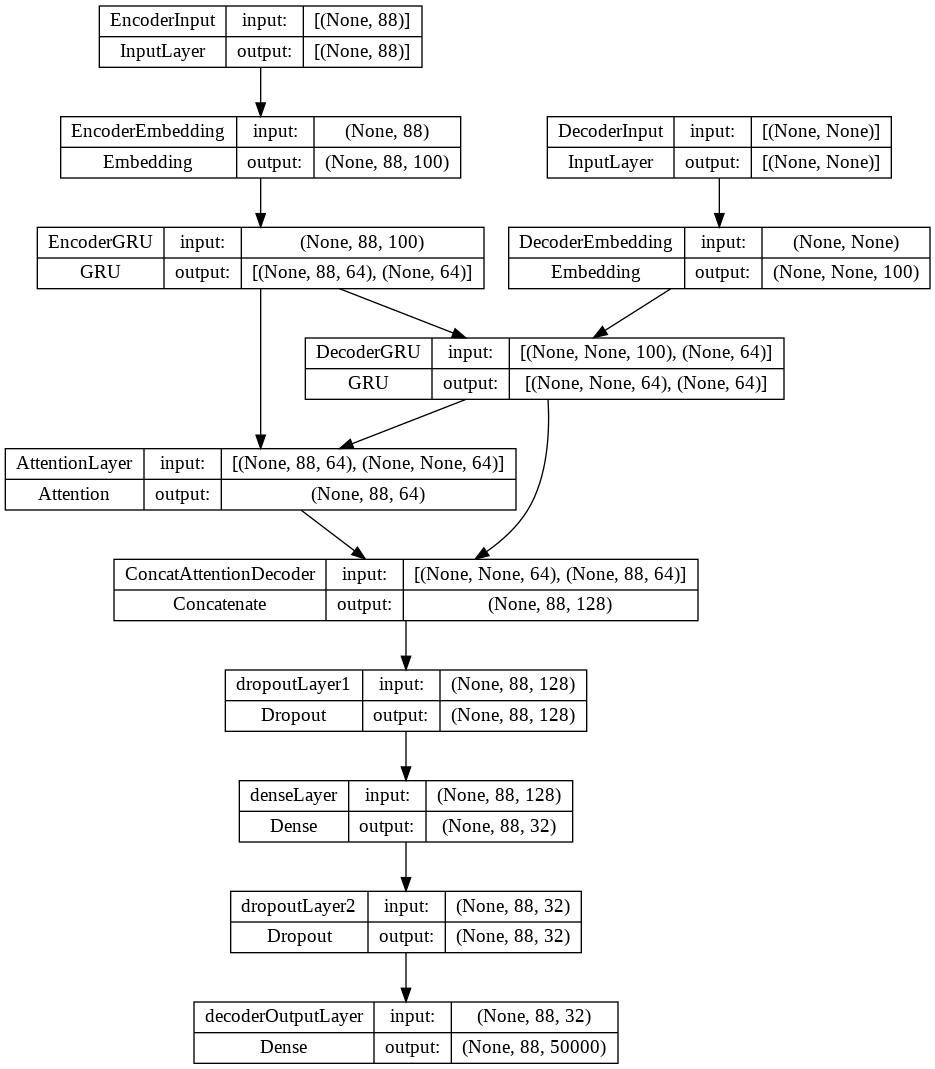

In [15]:
#encoder flow
input_en = Input(shape = (ultramax,),name = 'EncoderInput')
embEnc = Embedding(bpemb_en.vectors.shape[0],100,embeddings_initializer = tf.keras.initializers.Constant(bpemb_en.vectors), input_length=ultramax,trainable=False,name = 'EncoderEmbedding')(input_en)
encoder_out, encoder_state = GRU(units = 32, return_sequences = True, return_state = True,name = 'EncoderGRU')(embEnc)

#decoder flow
input_de = Input(shape=(None,),name = 'DecoderInput')
embDec = Embedding(bpemb_en.vectors.shape[0],100,embeddings_initializer = tf.keras.initializers.Constant(bpemb_en.vectors), input_length=ultramax,trainable=False,name = 'DecoderEmbedding')(input_de)
decoder_out, _ = GRU(units = 32, return_sequences = True, return_state = True,name = 'DecoderGRU')(embDec, initial_state=encoder_state)

#Defining Attention Layer
attentionLayer = Attention(name='AttentionLayer')
attentionOut = attentionLayer([encoder_out, decoder_out])

#Concatenating Decoder output and Attention output
decoder_concat_out = Concatenate(axis=-1,name='ConcatAttentionDecoder',)([decoder_out, attentionOut])

dropout = Dropout(0.3,name='dropoutLayer1')(decoder_concat_out)
dense = tf.keras.layers.Dense(32, activation="relu",kernel_initializer = tf.keras.initializers.HeNormal(),name='denseLayer')(dropout)
dropout = Dropout(0.3,name='dropoutLayer2')(dense)

decoderOutput = tf.keras.layers.Dense(bpemb_en.vectors.shape[0], activation="softmax",name='decoderOutputLayer')(dropout)

model = Model([input_en, input_de], decoderOutput,name='AttentionBased')
model.summary()

Model: "AttentionBased"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderInput (InputLayer)      [(None, 15)]         0           []                               
                                                                                                  
 DecoderInput (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 EncoderEmbedding (Embedding)   (None, 15, 100)      5000000     ['EncoderInput[0][0]']           
                                                                                                  
 DecoderEmbedding (Embedding)   (None, None, 100)    5000000     ['DecoderInput[0][0]']           
                                                                                     

In [16]:
filepath="modelAttention/weights-{epoch:02d}-{val_perplexity:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_perplexity', save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_perplexity', patience=10,min_delta=0.001,mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=3, min_lr=0.001)
callbacks_list = [checkpoint,earlystop,reduce_lr]

In [17]:
def perplexity(y_true, y_pred):
    '''
    Returns Perplexity
    '''
    SparseCrossEnt = tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.keras.backend.exp(tf.keras.backend.mean(SparseCrossEnt))

In [18]:
# Define the model that uses the Encoder and the Decoder

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy',perplexity])


In [19]:
History = model.fit([encInpTrain, decInpTrain], decOutTrain,batch_size=70,epochs=50,validation_split=0.2,callbacks = callbacks_list)

Epoch 1/50
18792/18792 [==============================] - 1545s 81ms/step - loss: 1.1872 - accuracy: 0.8003 - perplexity: 51.8591 - val_loss: 0.3614 - val_accuracy: 0.9525 - val_perplexity: 1.4377 - lr: 0.0010
Epoch 2/50
18792/18792 [==============================] - 1714s 91ms/step - loss: 0.6467 - accuracy: 0.8710 - perplexity: 1.9155 - val_loss: 0.2500 - val_accuracy: 0.9666 - val_perplexity: 1.2855 - lr: 0.0010
Epoch 3/50
18792/18792 [==============================] - 1826s 97ms/step - loss: 0.5679 - accuracy: 0.8848 - perplexity: 1.7688 - val_loss: 0.2155 - val_accuracy: 0.9714 - val_perplexity: 1.2417 - lr: 0.0010
Epoch 4/50
18792/18792 [==============================] - 1930s 103ms/step - loss: 0.5331 - accuracy: 0.8911 - perplexity: 1.7610 - val_loss: 0.1975 - val_accuracy: 0.9738 - val_perplexity: 1.2195 - lr: 0.0010
Epoch 5/50
18792/18792 [==============================] - 1523s 81ms/step - loss: 0.5136 - accuracy: 0.8947 - perplexity: 1.6746 - val_loss: 0.1855 - val_accuracy

KeyboardInterrupt: 

In [22]:
TXXT ='''loss: 1.1872 - accuracy: 0.8003 - perplexity: 51.8591 - val_loss: 0.3614 - val_accuracy: 0.9525 - val_perplexity: 1.4377 - lr: 0.0010###
loss: 0.6467 - accuracy: 0.8710 - perplexity: 1.9155 - val_loss: 0.2500 - val_accuracy: 0.9666 - val_perplexity: 1.2855 - lr: 0.0010###
loss: 0.5679 - accuracy: 0.8848 - perplexity: 1.7688 - val_loss: 0.2155 - val_accuracy: 0.9714 - val_perplexity: 1.2417 - lr: 0.0010###
loss: 0.5331 - accuracy: 0.8911 - perplexity: 1.7610 - val_loss: 0.1975 - val_accuracy: 0.9738 - val_perplexity: 1.2195 - lr: 0.0010###
loss: 0.5136 - accuracy: 0.8947 - perplexity: 1.6746 - val_loss: 0.1855 - val_accuracy: 0.9754 - val_perplexity: 1.2048 - lr: 0.0010###
loss: 0.5004 - accuracy: 0.8970 - perplexity: 1.6549 - val_loss: 0.1789 - val_accuracy: 0.9764 - val_perplexity: 1.1969 - lr: 0.0010###
loss: 0.4906 - accuracy: 0.8987 - perplexity: 1.6393 - val_loss: 0.1753 - val_accuracy: 0.9769 - val_perplexity: 1.1927 - lr: 0.0010###
loss: 0.4824 - accuracy: 0.9002 - perplexity: 1.6230 - val_loss: 0.1723 - val_accuracy: 0.9773 - val_perplexity: 1.1902 - lr: 0.0010###
loss: 0.4738 - accuracy: 0.9019 - perplexity: 1.6092 - val_loss: 0.1651 - val_accuracy: 0.9781 - val_perplexity: 1.1804 - lr: 0.0010###
loss: 0.4633 - accuracy: 0.9041 - perplexity: 1.5921 - val_loss: 0.1613 - val_accuracy: 0.9786 - val_perplexity: 1.1759 - lr: 0.0010###
loss: 0.4576 - accuracy: 0.9052 - perplexity: 1.5831 - val_loss: 0.1587 - val_accuracy: 0.9790 - val_perplexity: 1.1728 - lr: 0.0010###
loss: 0.4538 - accuracy: 0.9060 - perplexity: 1.5770 - val_loss: 0.1571 - val_accuracy: 0.9793 - val_perplexity: 1.1710 - lr: 0.0010###
loss: 0.4509 - accuracy: 0.9067 - perplexity: 1.5755 - val_loss: 0.1557 - val_accuracy: 0.9795 - val_perplexity: 1.1693 - lr: 0.0010###
loss: 0.4471 - accuracy: 0.9073 - perplexity: 1.5664 - val_loss: 0.1526 - val_accuracy: 0.9800 - val_perplexity: 1.1656 - lr: 0.0010###
loss: 0.4444 - accuracy: 0.9077 - perplexity: 1.5622 - val_loss: 0.1515 - val_accuracy: 0.9799 - val_perplexity: 1.1644 - lr: 0.0010
'''

In [23]:
columns_and_values = TXXT.split("###")
columns = ['loss', 'accuracy', 'perplexity', 'val_loss', 'val_accuracy', 'val_perplexity','lr']
keyVals = {'loss':[], 'accuracy':[], 'perplexity':[], 'val_loss':[], 'val_accuracy':[], 'val_perplexity':[],'lr':[]}
for column_and_value in columns_and_values:
    vsla = column_and_value.split(' - ')
    for metr,strsss in zip(columns,vsla):
        keyVals[metr].append(float(strsss.split(': ')[1])) 

In [24]:
import matplotlib.pyplot as plt

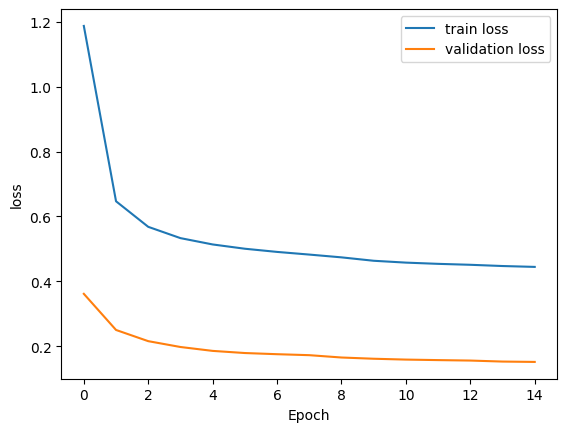

In [25]:
plt.plot(keyVals['loss'])
plt.plot(keyVals['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

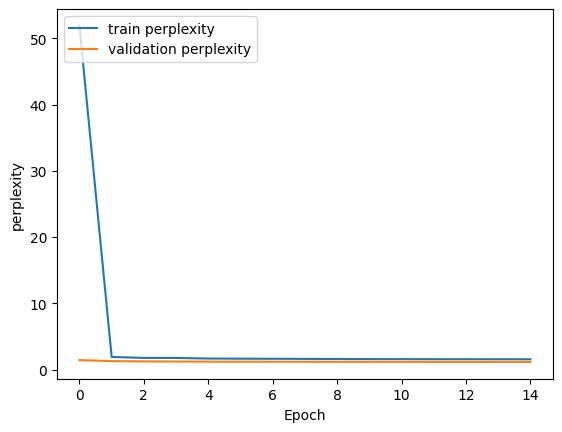

In [26]:
plt.plot(keyVals['perplexity'])
plt.plot(keyVals['val_perplexity'])
plt.ylabel('perplexity')
plt.xlabel('Epoch')
plt.legend(['train perplexity', 'validation perplexity'], loc='upper left')
plt.show()

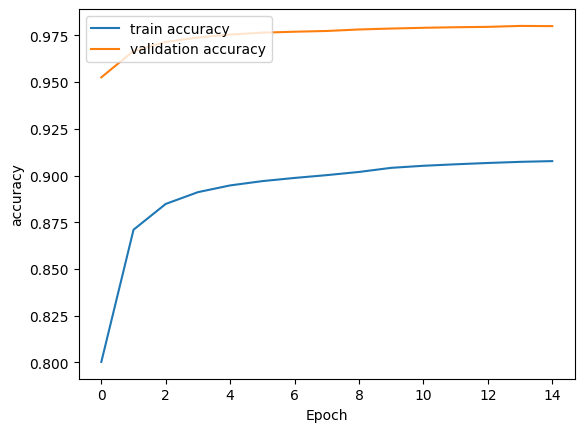

In [27]:
plt.plot(keyVals['accuracy'])
plt.plot(keyVals['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
plt.show()

### Results

In [28]:
loadModel = tf.keras.models.load_model('modelAttention\weights-15-1.1644.hdf5',custom_objects = {'perplexity':perplexity})

In [29]:
Loss,Accuracy,Perplexity = loadModel.evaluate([encInpTest, decInpTest], decOutTest)
print('Loss:   ',Loss)
print('Accuracy:   ',Accuracy)
print('Perplexity:   ',Perplexity)

22021/22021 [==============================] - 642s 29ms/step - loss: 0.1516 - accuracy: 0.9799 - perplexity: 1.1687
Loss:    0.15155184268951416
Accuracy:    0.9799302220344543
Perplexity:    1.168709635734558


### Comparing Results with Model Without Attention Laeyer

In [30]:
from prettytable import PrettyTable

myTable = PrettyTable(["Model Name","Loss", "Accuracy", "Perplexity"])
myTable.add_row(["EnCoder Decoder Model Without Attention Layer", "1.67", "0.74", "5.45"])
myTable.add_row(["EnCoder Decoder Model With Attention Layer", "0.15", "0.97", "1.16"])
  
print(myTable)

+-----------------------------------------------+------+----------+------------+
|                   Model Name                  | Loss | Accuracy | Perplexity |
+-----------------------------------------------+------+----------+------------+
| EnCoder Decoder Model Without Attention Layer | 1.67 |   0.74   |    5.45    |
|   EnCoder Decoder Model With Attention Layer  | 0.15 |   0.97   |    1.16    |
+-----------------------------------------------+------+----------+------------+
